## 导入包

In [2]:
0.99**365

0.025517964452291125

In [3]:
1.01**365

37.78343433288728

In [1]:
import torch
import torch.nn as nn

## nn.RNNCell

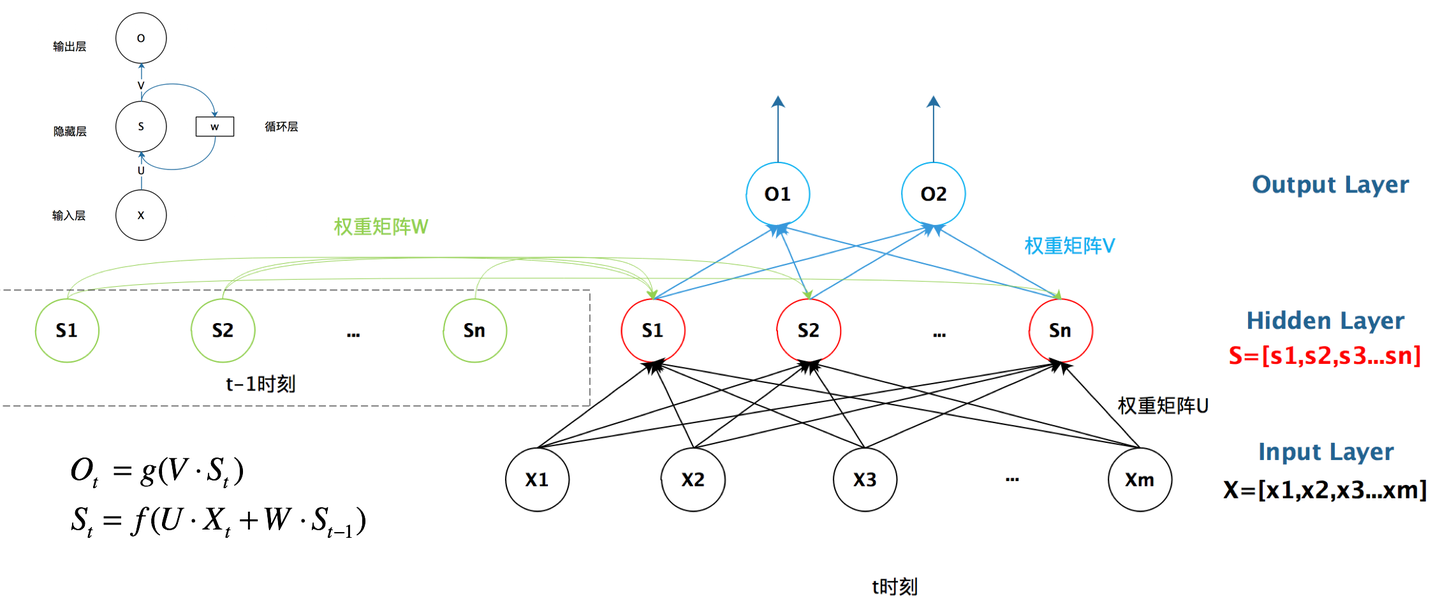

图片来源： [一文搞懂RNN（循环神经网络）基础篇](https://zhuanlan.zhihu.com/p/30844905)


In [5]:
rnn_cell = nn.RNNCell(input_size=4, hidden_size=3)
batch_size = 1
x = torch.randn(batch_size, 3, 4)
# n代表批次数 t代表时间维度 e代表每个时间步的特征数
n, t, e = x.shape

# 为了提取每个时刻的的输出值
hx = torch.zeros(batch_size, 3)
for i in range(t):
    hx = rnn_cell(x[:, i, :], hx)
    # 将更新后的隐藏状态赋值给 oi，这里 oi 代表当前时间步的输出
    oi = hx
    print(oi)

tensor([[-0.1842, -0.4569,  0.7622]], grad_fn=<TanhBackward0>)
tensor([[0.6670, 0.8398, 0.6536]], grad_fn=<TanhBackward0>)
tensor([[0.7971, 0.2575, 0.2604]], grad_fn=<TanhBackward0>)


In [6]:
x[:, i, :].shape

torch.Size([1, 4])

In [7]:
# 查看权重和偏置大小
for name, param in rnn_cell.named_parameters():
    if 'weight' in name:
        print(f"{name}: {param.size()}")
        # print(f"{name}: {param}")

print ("=====================")

for name, param in rnn_cell.named_parameters():
    if 'bias' in name:
        print(f"{name}: {param.size()}")
        # print(f"{name}: {param}")

weight_ih: torch.Size([3, 4])
weight_hh: torch.Size([3, 3])
bias_ih: torch.Size([3])
bias_hh: torch.Size([3])


In [10]:
# 设置模型为评估模式
rnn_cell.eval()

# 创建示例输入
dummy_input = torch.randn(batch_size, 4)

# 导出模型为 ONNX 格式
output_file = "rnn_cell.onnx"
torch.onnx.export(rnn_cell, dummy_input, output_file,
                  export_params=True,        # 存储训练过的参数
                  opset_version=10,         # ONNX 版本
                  do_constant_folding=True, # 是否执行常量折叠优化
                  input_names=['input'],    # 输入名称
                  output_names=['output'],  # 输出名称
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # 批次大小动态
                  )

print(f"ONNX model exported to {output_file}")

OnnxExporterError: Module onnx is not installed!

In [42]:
import netron

# 使用 netron 查看 ONNX 模型
netron.start(output_file)

Serving 'rnn_cell.onnx' at http://localhost:18756


('localhost', 18756)

## nn.RNN

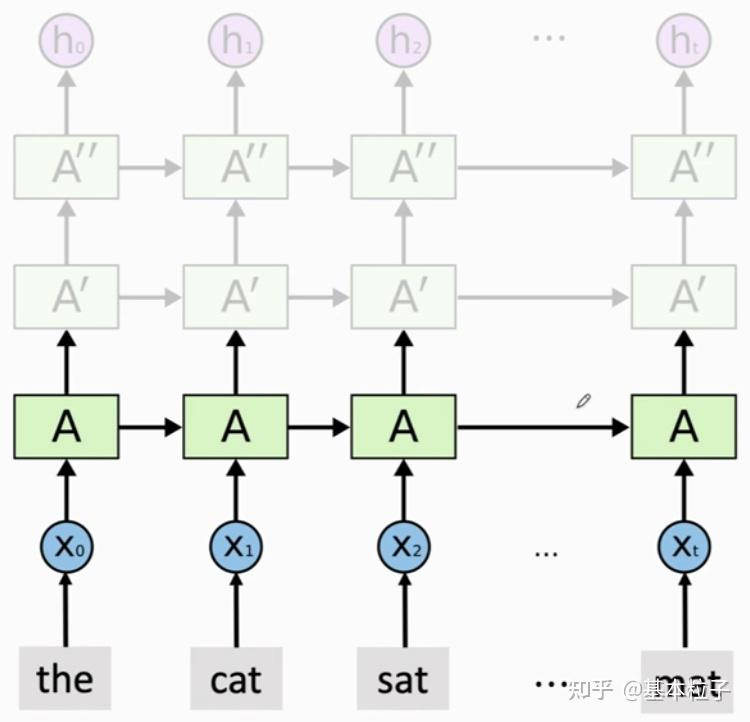

图片来源： [RNN的变种-多层RNN与双向RNN及其在torch中的实现](https://zhuanlan.zhihu.com/p/519965073)

In [6]:
# input_size代表输入特征的数量  hidden_size代表纵向的层数  num_layers代表横向的层数(记忆的层数)
rnn = nn.RNN(input_size=5, hidden_size=6, num_layers=3, batch_first=True)
# 时间步指的是序列中的单个元素或单个点
# 一次处理三个样本 每个样本有四个时间步 每个时间步有五个特征
x = torch.randn(3, 4, 5)
r, r00 = rnn(x)
print(r.shape)

torch.Size([3, 4, 6])


`nn.RNN`是一个循环神经网络（RNN）层的实现。具有以下参数：

- `input_size=5`：表示输入特征的数量。在这种情况下，网络的每个输入向量将有5个特征。

- `hidden_size=6`：表示隐藏状态的大小。RNN的每个隐藏状态将是一个维度为6的向量。

- `num_layers=3`：表示RNN堆叠的层数。将有3个RNN层堆叠在一起。堆叠的RNN可以捕获更复杂的序列模式，因为每一层都可以学习从上一层提取的隐藏状态的不同表示。

- `batch_first=True`：这个参数指定了输入和输出张量的形状。当设置为`True`时，输入和输出张量的形状将是`(batch, seq, feature)`，其中`batch`是批次大小，`seq`是序列长度，`feature`是每个时间步的特征数量。如果设置为`False`，形状将是`(seq, batch, feature)`。



In [7]:
r.shape, r00.shape

(torch.Size([3, 4, 6]), torch.Size([3, 3, 6]))

In [8]:
# 查看权重和偏置大小
for name, param in rnn.named_parameters():
    if 'weight' in name:
        print(f"{name}: {param.size()}")
        # print(f"{name}: {param}")

print ("=====================")

for name, param in rnn.named_parameters():
    if 'bias' in name:
        print(f"{name}: {param.size()}")
        # print(f"{name}: {param}")

weight_ih_l0: torch.Size([6, 5])
weight_hh_l0: torch.Size([6, 6])
weight_ih_l1: torch.Size([6, 6])
weight_hh_l1: torch.Size([6, 6])
bias_ih_l0: torch.Size([6])
bias_hh_l0: torch.Size([6])
bias_ih_l1: torch.Size([6])
bias_hh_l1: torch.Size([6])


In [9]:
rnn1 = nn.RNN(input_size=5, hidden_size=6, num_layers=2, batch_first=True)
rnn2 = nn.RNN(input_size=6, hidden_size=6, num_layers=1, batch_first=True)
r1, r11 = rnn1(x)
print (x.shape, r1.shape, r11.shape)
r2, r22 = rnn2(r1)
r = torch.concat([r1, r2], dim=2)
print(r.shape)

torch.Size([3, 4, 5]) torch.Size([3, 4, 6]) torch.Size([2, 3, 6])
torch.Size([3, 4, 12])


### r1 & r11
使用`nn.RNN`时，`r1`和`r11`分别代表不同的输出：

1. **`r1`**：这是RNN层在每个时间步的输出。具体来说，`r1`是一个三维张量，其形状为`(batch, seq_len, hidden_size)`（如果`batch_first=True`），其中`batch`是批次大小，`seq_len`是序列长度，`hidden_size`是隐藏状态的大小。`r1`包含了RNN在处理输入序列的每个时间步时生成的隐藏状态。

2. **`r11`**：这是RNN层在最后一个时间步的隐藏状态。它是一个三维张量，其形状为`(num_layers, batch, hidden_size)`。这里，`num_layers`是RNN层的数量，`batch`是批次大小，`hidden_size`是隐藏状态的大小。`r11`代表了序列处理完成后的最终隐藏状态，可以用于序列分类或作为下一个序列的初始隐藏状态。

`r1`和`r11`之间的联系在于：

- `r1`的最后一个时间步的输出（即`r1[:, -1, :]`）与`r11`最后一层的最后一个时间步的隐藏状态是相同的（即`r11[-1, :, :]`）。这是因为在RNN中，每个时间步的输出同时也是下一个时间步的输入，因此在最后一个时间步，输出隐藏状态被用作序列的最终隐藏状态。

- 在多层RNN中，`r11`包含了所有层的最终隐藏状态，而`r1`的最后一个时间步的输出只对应于最后一层的隐藏状态。

简而言之，`r11`可以看作是`r1`在时间维度上的最后一个元素的扩展，包含了所有层的信息，而`r1`包含了序列中每个时间步的输出隐藏状态。


In [10]:
# 查看参数
print("Input size:", rnn1.input_size)
print("Hidden size:", rnn1.hidden_size)
print("Number of layers:", rnn1.num_layers)
print("Batch first:", rnn1.batch_first)
print("Bias:", rnn1.bias is not None)  # bias is a parameter tensor, not a boolean
print("Dropout:", rnn1.dropout)
print("Bidirectional:", rnn1.bidirectional)

Input size: 5
Hidden size: 6
Number of layers: 2
Batch first: True
Bias: True
Dropout: 0.0
Bidirectional: False


In [11]:
# 查看权重和偏置大小
for name, param in rnn1.named_parameters():
    if 'weight' in name:
        print(f"{name}: {param.size()}")
        # print(f"{name}: {param}")

print ("=====================")

for name, param in rnn1.named_parameters():
    if 'bias' in name:
        print(f"{name}: {param.size()}")
        # print(f"{name}: {param}")

weight_ih_l0: torch.Size([6, 5])
weight_hh_l0: torch.Size([6, 6])
weight_ih_l1: torch.Size([6, 6])
weight_hh_l1: torch.Size([6, 6])
bias_ih_l0: torch.Size([6])
bias_hh_l0: torch.Size([6])
bias_ih_l1: torch.Size([6])
bias_hh_l1: torch.Size([6])


In [12]:
r1.shape, r11.shape, r2.shape, r22.shape

(torch.Size([3, 4, 6]),
 torch.Size([2, 3, 6]),
 torch.Size([3, 4, 6]),
 torch.Size([1, 3, 6]))

In [13]:
r1

tensor([[[ 0.0354,  0.3065,  0.2609, -0.7038,  0.1577,  0.4369],
         [-0.0196,  0.4020, -0.1655, -0.8080,  0.3624,  0.5619],
         [ 0.1958,  0.2018,  0.1608, -0.9132,  0.2444,  0.5077],
         [-0.1003,  0.4461,  0.1361, -0.7833,  0.2894,  0.4205]],

        [[-0.1758, -0.2555,  0.5632, -0.5544, -0.4903,  0.4264],
         [-0.2864,  0.4743,  0.2391, -0.7350, -0.0823,  0.4043],
         [-0.2972,  0.4405, -0.0098, -0.8132,  0.2272,  0.4189],
         [ 0.1102,  0.0781,  0.2035, -0.8759,  0.0032,  0.6678]],

        [[-0.1374,  0.4409,  0.2093, -0.2852,  0.3369,  0.0547],
         [-0.2046, -0.0644,  0.4359, -0.7933, -0.4120,  0.3482],
         [-0.5964, -0.0485,  0.5102, -0.2107, -0.5451,  0.6160],
         [-0.6471,  0.0171,  0.5131, -0.2865, -0.3430,  0.2048]]],
       grad_fn=<TransposeBackward1>)

In [14]:
r11

tensor([[[-0.6408,  0.1606, -0.2362, -0.2668, -0.1966, -0.3021],
         [ 0.1505, -0.2486,  0.5523, -0.3256,  0.3733,  0.5916],
         [ 0.2667,  0.0710, -0.1932, -0.6029, -0.4218, -0.7548]],

        [[-0.1003,  0.4461,  0.1361, -0.7833,  0.2894,  0.4205],
         [ 0.1102,  0.0781,  0.2035, -0.8759,  0.0032,  0.6678],
         [-0.6471,  0.0171,  0.5131, -0.2865, -0.3430,  0.2048]]],
       grad_fn=<StackBackward0>)

In [15]:
r1[:,-1,:]

tensor([[-0.1003,  0.4461,  0.1361, -0.7833,  0.2894,  0.4205],
        [ 0.1102,  0.0781,  0.2035, -0.8759,  0.0032,  0.6678],
        [-0.6471,  0.0171,  0.5131, -0.2865, -0.3430,  0.2048]],
       grad_fn=<SliceBackward0>)

In [16]:
r11[-1,:,:]

tensor([[-0.1003,  0.4461,  0.1361, -0.7833,  0.2894,  0.4205],
        [ 0.1102,  0.0781,  0.2035, -0.8759,  0.0032,  0.6678],
        [-0.6471,  0.0171,  0.5131, -0.2865, -0.3430,  0.2048]],
       grad_fn=<SliceBackward0>)

In [17]:
r22

tensor([[[ 0.1888,  0.6455, -0.3021, -0.1538,  0.1166,  0.2487],
         [ 0.2187,  0.5949, -0.3668, -0.2027,  0.2735,  0.3304],
         [ 0.5741,  0.5561, -0.7763,  0.1062,  0.3953,  0.1561]]],
       grad_fn=<StackBackward0>)

### onnx

In [18]:
# 设置模型为评估模式
rnn.eval()

# 创建示例输入
dummy_input = torch.randn(3, 4, 5)

# 导出模型为 ONNX 格式
output_file = "rnn.onnx"
torch.onnx.export(rnn, dummy_input, output_file,
                  export_params=True,        # 存储训练过的参数
                  opset_version=10,         # ONNX 版本
                  do_constant_folding=True, # 是否执行常量折叠优化
                  input_names=['input'],    # 输入名称
                  output_names=['output', 'output1'],  # 输出名称
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}} # 批次大小动态
                  )

print(f"ONNX model exported to {output_file}")

ONNX model exported to rnn.onnx


/Users/hayden/anaconda3/envs/ait/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [19]:
import netron

# 使用 netron 查看 ONNX 模型
netron.start(output_file)

Serving 'rnn.onnx' at http://localhost:8081


('localhost', 8081)

In [20]:
import onnx

model = onnx.load(output_file)
model.graph

node {
  input: "input"
  output: "/Shape_output_0"
  name: "/Shape"
  op_type: "Shape"
}
node {
  output: "/Constant_output_0"
  name: "/Constant"
  op_type: "Constant"
  attribute {
    name: "value"
    t {
      data_type: 7
      raw_data: "\000\000\000\000\000\000\000\000"
    }
    type: TENSOR
  }
}
node {
  input: "/Shape_output_0"
  input: "/Constant_output_0"
  output: "/Gather_output_0"
  name: "/Gather"
  op_type: "Gather"
  attribute {
    name: "axis"
    i: 0
    type: INT
  }
}
node {
  output: "/Constant_1_output_0"
  name: "/Constant_1"
  op_type: "Constant"
  attribute {
    name: "value"
    t {
      dims: 1
      data_type: 7
      raw_data: "\002\000\000\000\000\000\000\000"
    }
    type: TENSOR
  }
}
node {
  input: "/Gather_output_0"
  output: "/Unsqueeze_output_0"
  name: "/Unsqueeze"
  op_type: "Unsqueeze"
  attribute {
    name: "axes"
    ints: 0
    type: INTS
  }
}
node {
  output: "/Constant_2_output_0"
  name: "/Constant_2"
  op_type: "Constant"
  at

## StockRNN

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设data是一个形状为(100, 5)的张量，包含100天的股票特征
data = torch.randn(100, 5)   # 开盘价、最高价、最低价、收盘价和交易量

# 定义时间窗口大小为4，即使用前4天的数据来预测第5天的收盘价
window_size = 4

# 构建x和y
x = []
y = []

for i in range(len(data) - window_size):
    # 确保每个样本都是形状为(1, window_size, 5)的张量
    # 从 data 张量中提取从索引 i 开始到 i + window_size（不包括 i + window_size）的行
    # unsqueeze(0) 在提取的子张量前面增加一个维度，将其从形状 (window_size, 5) 变为 (1, window_size, 5)，
    # 这样做是为了符合 PyTorch RNN 层的输入要求，即输入数据的形状应该是 (batch_size, seq_len
    sample_x = data[i:i + window_size].unsqueeze(0)
    x.append(sample_x)
    y.append(data[i + window_size, 3])  # 假设我们预测的是第4个特征，即收盘价

# 将x和y转换为PyTorch张量
x = torch.cat(x, dim=0)  # 沿着第一个维度（批次维度）堆叠张量
y = torch.tensor(y, dtype=torch.float32)  # y的形状将是(96,)

# 定义RNN模型
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)  # 预测一个值，即收盘价

    def forward(self, x):
        out, _ = self.rnn(x)
        # 从RNN层的输出中提取最后一个时间步的输出
        # : 表示选择所有的批次（batch_size）
        # -1 表示选择最后一个时间步（seq_len）
        # : 表示选择所有的特征（hidden_size）
        out = out[:, -1, :]
        out = self.linear(out)
        return out

# 实例化模型
# input_size=模型的输入特征数量  hidden_size=RNN层的隐藏单元数量   num_size=RNN层的数量
# 其中hidden_size 和 num_size 都可以增加
model = StockRNN(input_size=5, hidden_size=6, num_layers=1)

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失，适用于回归问题
optimizer = optim.SGD(model.parameters(), lr=0.01)  # SGD优化器

# 训练模型
# 增加训练轮数epoch会更充分地训练但也可能过拟合 占更多资源和时间
epochs = 3
# 增加大批次的梯度更新可能不够频繁，减少了模型在训练过程中的“探索”
# 较小的 batch_size 通常有助于模型捕捉数据中的噪声和细节，可能提高泛化能力
batch_size = 3
num_batches = len(x) // batch_size

for epoch in range(epochs):
    for batch in range(num_batches):
        # 获取一个批次的数据
        start = batch * batch_size
        end = start + batch_size
        batch_x = x[start:end]  # 形状为(batch_size, 4, 5)
        batch_y = y[start:end].unsqueeze(-1)  # 形状为(batch_size, 1)

        # 前向传播
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)  # 现在不需要额外增加一个维度

        # 反向传播和优化
        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

    print(f'Epoch [{epoch+1}/{epochs}], Batch Loss: {loss.item():.4f}')

print("Training complete")

Epoch [1/3], Batch Loss: 0.8209
Epoch [2/3], Batch Loss: 0.7999
Epoch [3/3], Batch Loss: 0.8210
Training complete


In [22]:
data[:6]

tensor([[ 0.2500, -0.1052, -1.4543,  0.0957, -0.1419],
        [ 0.0113,  0.6755,  0.6795, -0.5104, -0.0586],
        [ 1.5830, -0.9862, -0.9393,  0.0766, -0.0946],
        [ 1.4679, -0.3008, -1.1244,  0.7913, -0.8832],
        [-1.1453,  1.6841, -0.0590, -0.0924,  0.1332],
        [ 0.1966, -0.7447,  0.5917, -0.2587, -0.6675]])

In [23]:
x[0],

(tensor([[ 0.2500, -0.1052, -1.4543,  0.0957, -0.1419],
         [ 0.0113,  0.6755,  0.6795, -0.5104, -0.0586],
         [ 1.5830, -0.9862, -0.9393,  0.0766, -0.0946],
         [ 1.4679, -0.3008, -1.1244,  0.7913, -0.8832]]),)

In [24]:
y[0], y[1]

(tensor(-0.0924), tensor(-0.2587))

In [25]:
x[1]

tensor([[ 0.0113,  0.6755,  0.6795, -0.5104, -0.0586],
        [ 1.5830, -0.9862, -0.9393,  0.0766, -0.0946],
        [ 1.4679, -0.3008, -1.1244,  0.7913, -0.8832],
        [-1.1453,  1.6841, -0.0590, -0.0924,  0.1332]])

In [26]:
print (model)

StockRNN(
  (rnn): RNN(5, 6, batch_first=True)
  (linear): Linear(in_features=6, out_features=1, bias=True)
)


## nn.RNN & nn.RNNCell

In [27]:
rnn = nn.RNN(input_size=5, hidden_size=6, num_layers=1, batch_first=True)
rnn_cell = nn.RNNCell(input_size=5, hidden_size=6)
for name, param in rnn.named_parameters():
    print(name, param.shape)
print("=" * 10)
for name, param in rnn_cell.named_parameters():
    print(name, param.shape)

rnn_cell.weight_ih = rnn.weight_ih_l0
rnn_cell.weight_hh = rnn.weight_hh_l0
rnn_cell.bias_ih = rnn.bias_ih_l0
rnn_cell.bias_hh = rnn.bias_hh_l0

batch_size = 1
x = torch.randn(batch_size, 3, 5)
output, output1 = rnn(x)
print(output)
n, t, e = x.shape
print ('='*50)
# 为了提取每个时刻的的输出值
hx = torch.zeros(batch_size, 6)
for i in range(t):
    hx = rnn_cell(x[:, i, :], hx)
    oi = hx  # RNN的状态信息就是输出信息
    print(oi)

weight_ih_l0 torch.Size([6, 5])
weight_hh_l0 torch.Size([6, 6])
bias_ih_l0 torch.Size([6])
bias_hh_l0 torch.Size([6])
weight_ih torch.Size([6, 5])
weight_hh torch.Size([6, 6])
bias_ih torch.Size([6])
bias_hh torch.Size([6])
tensor([[[-0.5611, -0.9438, -0.4502,  0.4019,  0.1062,  0.3785],
         [-0.4522, -0.7398, -0.7554,  0.3610, -0.7396,  0.6891],
         [-0.1913, -0.5028,  0.3856,  0.0317,  0.1423,  0.4699]]],
       grad_fn=<TransposeBackward1>)
tensor([[-0.5611, -0.9438, -0.4502,  0.4019,  0.1062,  0.3785]],
       grad_fn=<TanhBackward0>)
tensor([[-0.4522, -0.7398, -0.7554,  0.3610, -0.7396,  0.6891]],
       grad_fn=<TanhBackward0>)
tensor([[-0.1913, -0.5028,  0.3856,  0.0317,  0.1423,  0.4699]],
       grad_fn=<TanhBackward0>)


In [28]:
output[:, -1, :]

tensor([[-0.1913, -0.5028,  0.3856,  0.0317,  0.1423,  0.4699]],
       grad_fn=<SliceBackward0>)

In [29]:
output1[-1,:,:]

tensor([[-0.1913, -0.5028,  0.3856,  0.0317,  0.1423,  0.4699]],
       grad_fn=<SliceBackward0>)

## tensorboard

In [21]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/rnn_experiment')

FailedPreconditionError: runs/rnn_experiment is not a directory

In [23]:
rnn = nn.RNN(input_size=5, hidden_size=6, num_layers=2, batch_first=True)
batch_size = 2
x = torch.randn(batch_size, 3, 5)
# 假设net是您的RNN模型，images是输入数据
writer.add_graph(rnn, x)
writer.close()

FailedPreconditionError: runs/rnn_experiment is not a directory

In [24]:
!tensorboard --logdir=runs

'tensorboard' 不是内部或外部命令，也不是可运行的程序
或批处理文件。
